<a href="https://colab.research.google.com/github/cidcom/satellite-cloud-removal-dip/blob/main/01-Example-Use-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# GitHub import and package installation
These two actions should take about 1-2 minutes. Then you're ready to go.

🚀 **To use GPU go to** `Runtime` -> `Change Runtime Type` -> `Hardware Accelerator: GPU`

In [2]:
! git clone https://github.com/cidcom/satellite-cloud-removal-dip

Cloning into 'satellite-cloud-removal-dip'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 63 (delta 14), reused 42 (delta 7), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [3]:
!pip install -q torch==1.10.0 torchvision numpy rasterio==1.0.21 git+https://github.com/PyTorchLightning/pytorch-lightning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.7 MB 1.5 MB/s 
     |████████████████████████████████| 134 kB 38.6 MB/s 
     |████████████████████████████████| 596 kB 51.1 MB/s 
     |████████████████████████████████| 397 kB 42.5 MB/s 
     |████████████████████████████████| 1.1 MB 41.7 MB/s 
     |████████████████████████████████| 271 kB 48.6 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [4]:
import sys
sys.path.append('./satellite-cloud-removal-dip/')

from src import *
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20, 10)

## Example Cloud Image with a Cloud-Shadow Mask 🌥

In [5]:
s2_image = s2_preprocess('./satellite-cloud-removal-dip/data/example_sample/S2/S1_3c120554-3873-4de2-bcc3-23ae00d28c4f_S2_76dac503-47d7-446b-b92d-56f4dd10f8e2_0_0_256x256.tif')

with open('./satellite-cloud-removal-dip/data/example_sample/mask.npy', 'rb') as f:
    mask = np.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


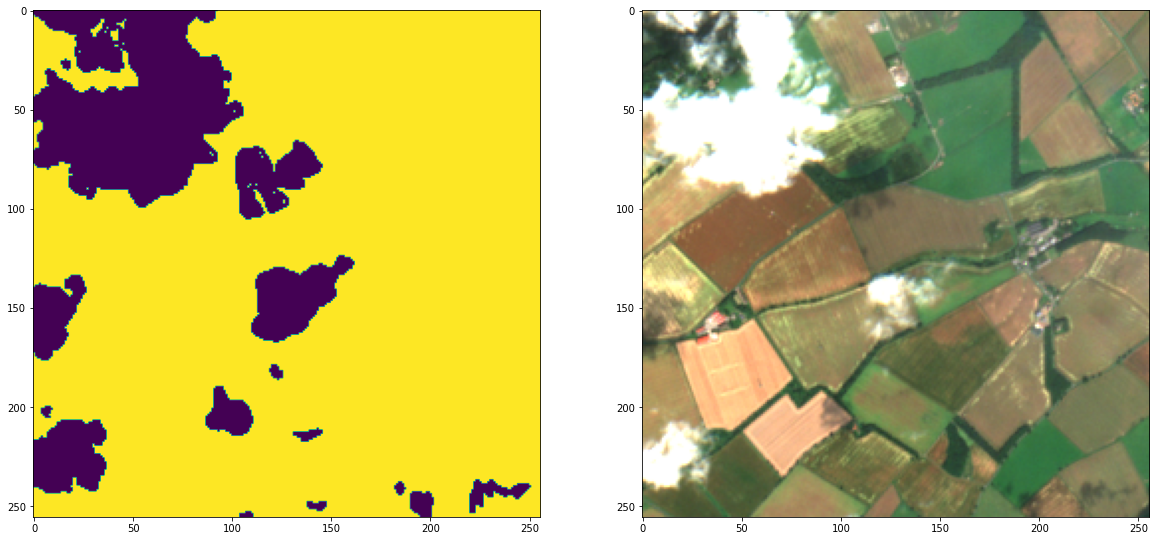

In [6]:
plt.subplot(1,2,1)
plt.imshow(mask)
plt.subplot(1,2,2)
plt.imshow(s2_image)

### Supporting Data: Sentinel-1 SAR and a yearly Sentinel-2 average from 2019

In [7]:
s1_image = s1_preprocess('./satellite-cloud-removal-dip/data/example_sample/S1/S1_3c120554-3873-4de2-bcc3-23ae00d28c4f_S2_76dac503-47d7-446b-b92d-56f4dd10f8e2_0_0_256x256.tif',
                         to_db = True)

with open('./satellite-cloud-removal-dip/data/2019_mean.npy', 'rb') as f:
    s2_mean = np.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


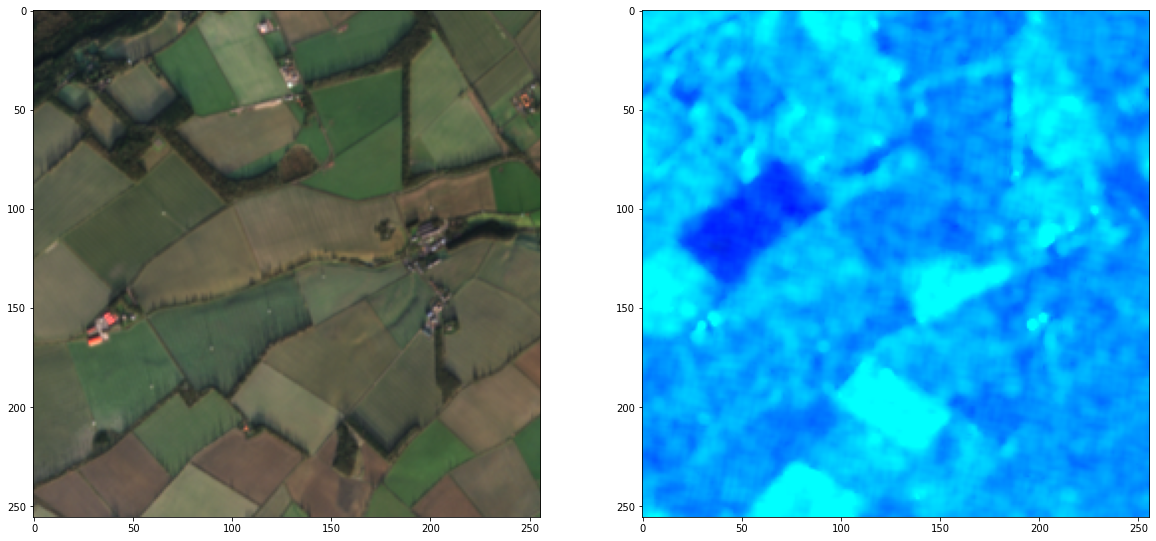

In [8]:
plt.subplot(1,2,1)
plt.imshow(s2_mean)
plt.subplot(1,2,2)
plt.imshow(rgb(s1_image))

## Initialize Model and Train 🏋
The ttraining should take about 10 minutes with the resources provided by Google Colab

In [9]:
my_model = LitDIP()

my_model.set_target([s2_image, s2_mean, s1_image])
my_model.set_mask([mask,
                   np.ones(mask.shape),
                   np.ones(mask.shape)])

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
trainer = pl.Trainer(
    max_epochs = 4,            
    checkpoint_callback=False,
    logger=False,
    gpus = [0]
)
trainer.fit(my_model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:318: LightningDeprecationWarning: The `LightningModule.on_pretrain_routine_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_fit_start` instead.
  f"The `LightningModule.{hook}` hook was deprecated in v1.6 and"
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2.4 M 
-------------

Training: 0it [00:00, ?it/s]

In [12]:
result, _, _ = my_model.output() # the two unused (_) variables correspond to s2_mean reconstruction and s1_image reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Results')

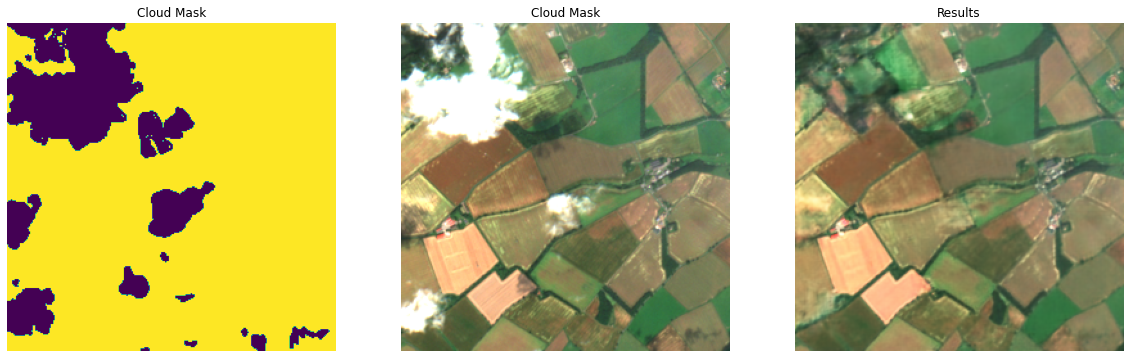

In [13]:
plt.subplot(1,3,1)
plt.imshow(mask)
plt.axis('off')
plt.title('Cloud Mask')
plt.subplot(1,3,2)
plt.imshow(s2_image)
plt.axis('off')
plt.title('Cloud Mask')
plt.subplot(1,3,3)
plt.imshow(result)
plt.axis('off')
plt.title('Results')